# Test

To begin with, we will create two classes `MyNN` and `GeneticAlgorithm`, which will respectively represent a neural network and a genetic algorithm

In [19]:
from matplotlib import pyplot as plt
import numpy as np
import random
from sklearn.metrics import mean_squared_error
import torch.nn.init as init
import torch.nn as nn

def activation_function(x):  # Sigmoid function
    return 1 / (1 + np.exp(-x))

def function_z(x, y):
    return np.cos(abs(y)) + np.sin(x + y)

zero_layer_nn, first_layer_nn, second_layer_nn, third_layer_nn, fourth_layer_nn, fifth_layer_nn, last_layer_nn = 2, 4, 8, 8, 6, 6, 1

class MyNN:
    def __init__(self):
        self.weights = [
            np.random.rand(zero_layer_nn, first_layer_nn),
            np.random.rand(first_layer_nn, second_layer_nn),
            np.random.rand(second_layer_nn, third_layer_nn),
            np.random.rand(third_layer_nn, fourth_layer_nn),
            np.random.rand(fourth_layer_nn, fifth_layer_nn),
            np.random.rand(fifth_layer_nn, last_layer_nn)
        ]

    def forward_propagate(self, inputs):
        layers = [inputs]
        for i in range(len(self.weights)):
            layers.append(activation_function(np.dot(layers[i], self.weights[i])))
        return layers[-1]
    
    def learn_errors(self, x_train, y_train):
        errors = []
        for x in x_train:
            for y in y_train:
                z = function_z(x, y)
                prediction = self.forward_propagate(np.array([x, y]))
                error = mean_squared_error(np.array([z]), prediction)
                errors.append(error)
        return errors


class GeneticAlgorithm:
    def __init__(self, population_size, mutation_rate, generations_number):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.generations_number = generations_number
        self.population = self._generate_population(population_size)

    def _generate_population(self, population_size):
        return [MyNN() for _ in range(population_size)]
    
    def fitness(self, x, y, z):  # Fitness evaluation for each individual in the population
        fitness_scores = []
        for network in self.population:
            output = network.forward_propagate(np.array([x, y]))
            error = np.mean(np.square(output - z))
            fitness_scores.append(1 / (error + 1e-6))  # Avoid division by zero
        return fitness_scores
    
    def select_parents(self, fitness_scores):
        return random.choices(self.population, weights=fitness_scores, k=2)
    
    def crossover(self, parent1, parent2):
        child = MyNN()
        for i in range(len(child.weights)):
            crossover_point = random.randint(0, len(parent1.weights[i]))
            child.weights[i][:crossover_point] = parent1.weights[i][:crossover_point]
            child.weights[i][crossover_point:] = parent2.weights[i][crossover_point:]
        return child
    
    def mutate(self, network):
        for i in range(len(network.weights)):
            mutation_mask = np.random.rand(*network.weights[i].shape) < self.mutation_rate
            network.weights[i] += np.random.randn(*network.weights[i].shape) * mutation_mask * 0.1
        return network
    
    def one_gen_cycle(self, x, y, z):
        # One iteration of the genetic algorithm
        fitness_scores = self.fitness(x, y, z)
        new_population = []
        for _ in range(self.population_size):
            parent1, parent2 = self.select_parents(fitness_scores)
            child = self.crossover(parent1, parent2)
            child = self.mutate(child)
            new_population.append(child)
        self.population = new_population
        return min(fitness_scores)
    
    def main_cycle(self, x_train, y_train):
        # Main cycle of the genetic algorithm
        print("Executing genetic algorithm...")
        for gen in range(self.generations_number):
            min_errors = []
            for x in x_train:
                for y in y_train:
                    z = function_z(x, y)
                    min_errors.append(self.one_gen_cycle(x, y, z))
            print(f"Number of generations completed: {gen + 1}/100", end='\r')
        print()


Let's determine the parameters, train the neural network and estimate the resulting root mean square errors:

In [20]:
individuals_number = 10
mutation_rate = 0.01
generations_number = 100
genetic_algorithm = GeneticAlgorithm(individuals_number, mutation_rate, generations_number)
x_train = np.linspace(-1, 1, 20)
y_train = np.linspace(-1, 1, 20)

genetic_algorithm.main_cycle(x_train, y_train)

network = genetic_algorithm.population[0]
errors = network.learn_errors(x_train, y_train)
errors_middle = []

print("Assessment of obtained values:")
for i, (x, y) in enumerate(zip(x_train, y_train)):
    print(f"X value: {round(x, 1)}, Y value: {round(y, 1)}, Mean square error: {errors[i]}")
    errors_middle.append(errors[i])


Executing genetic algorithm...
Number of generations completed: 100/100
Assessment of obtained values:
X value: -1.0, Y value: -1.0, Mean square error: 1.2152296573437529
X value: -0.9, Y value: -0.9, Mean square error: 1.1143874538004055
X value: -0.8, Y value: -0.8, Mean square error: 1.0107267271425566
X value: -0.7, Y value: -0.7, Mean square error: 0.9063839295139597
X value: -0.6, Y value: -0.6, Mean square error: 0.803379517650093
X value: -0.5, Y value: -0.5, Mean square error: 0.703557375995731
X value: -0.4, Y value: -0.4, Mean square error: 0.6085333334611344
X value: -0.3, Y value: -0.3, Mean square error: 0.5196547169753339
X value: -0.2, Y value: -0.2, Mean square error: 0.4379723881501958
X value: -0.1, Y value: -0.1, Mean square error: 0.36422615109596423
X value: 0.1, Y value: 0.1, Mean square error: 0.2988438246804533
X value: 0.2, Y value: 0.2, Mean square error: 0.2419536684107493
X value: 0.3, Y value: 0.3, Mean square error: 0.19340926510516687
X value: 0.4, Y val

Let's build the graphs:

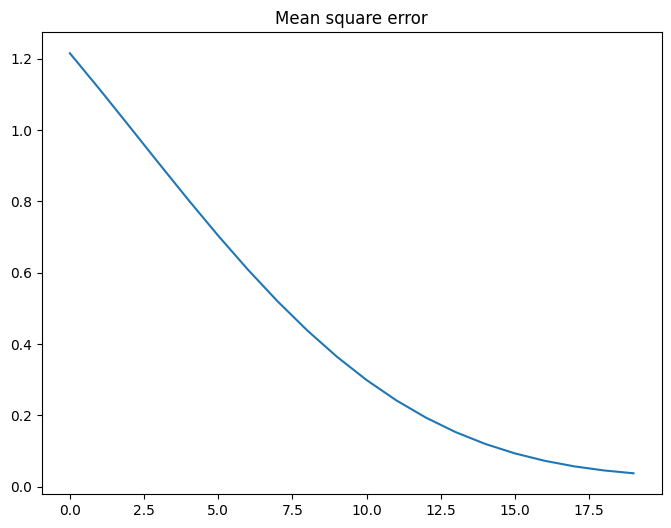

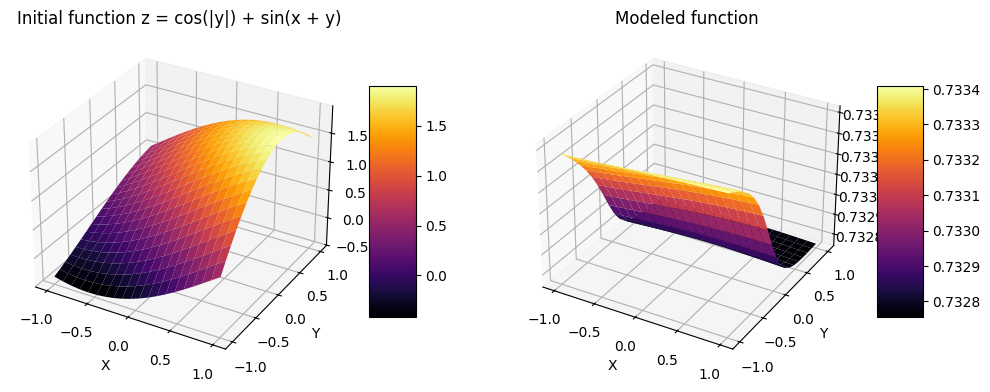

In [21]:
# Building a training graph in linear scale
plt.figure(figsize=(8, 6))
plt.plot(errors_middle)
plt.title('Mean square error')
plt.show()

Z_predicted_for_graph = np.zeros((20, 20))
x_values = np.linspace(-1, 1, 20)
y_values = np.linspace(-1, 1, 20)
z_values = np.array([[function_z(x, y) for x in x_values] for y in y_values])

for i, x in enumerate(x_values):
    for j, y in enumerate(y_values):
        prediction = network.forward_propagate(np.array([x, y]))
        Z_predicted_for_graph[i, j] = prediction[0]

figure = plt.figure(figsize=(12, 6))
X, Y = np.meshgrid(x_values, y_values)
actual_func = figure.add_subplot(121, projection='3d')
surface1 = actual_func.plot_surface(X, Y, z_values, cmap='inferno', edgecolor='none')
actual_func.set_title('Initial function z = cos(|y|) + sin(x + y)')
actual_func.set_xlabel('X')
actual_func.set_ylabel('Y')
actual_func.set_zlabel('Z')
figure.colorbar(surface1, ax=actual_func, shrink=0.5, aspect=5)

predicted_func = figure.add_subplot(122, projection='3d')
surface2 = predicted_func.plot_surface(X, Y, Z_predicted_for_graph, cmap='inferno', edgecolor='none')
predicted_func.set_title('Modeled function')
predicted_func.set_xlabel('X')
predicted_func.set_ylabel('Y')
predicted_func.set_zlabel('Z')
figure.colorbar(surface2, ax=predicted_func, shrink=0.5, aspect=5)
plt.show()
